In [1]:
from model import DenoisingUNet
from utils import *
from data import synthetic_mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch.nn as nn
import torch
import numpy as np
sampleRate = 68.27

# Training on synthetic data

In [2]:
N_sub = 32
batch_size = 32
hidden_layers = 6
learning_rate = 5e-4
num_epochs = 500

In [3]:
train_dataset = synthetic_mask_dataset(data_path='synthetic-data/train', f_min=1, f_max=10, N_sub=N_sub)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

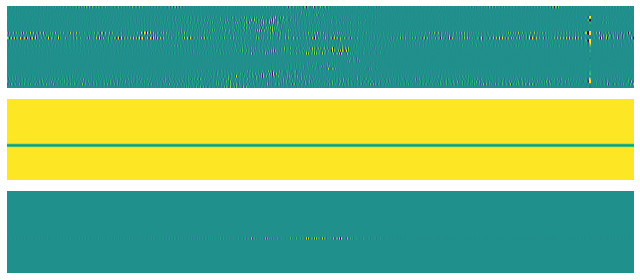

In [4]:
for eval,masks in train_loader:
    break
# Draw canvas
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 4))

# Show sample (without blanking)
axes[0].imshow(eval[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[0].axis("off")

# Show mask
axes[1].imshow(masks[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[1].axis("off")

masked_sample = eval*(1-masks)
# Show prediction target
axes[2].imshow(masked_sample[0, :, :], aspect="auto", vmin=-1, vmax=1, origin="upper")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [5]:
# GPU
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device is {device}.')

model = DenoisingUNet(input_bands=1, output_classes=1, hidden_channels=hidden_layers)
model.to(device)

# Mean Square Error 
criterion = nn.MSELoss()

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NVIDIA GeForce RTX 2070
device is cuda:0.


In [6]:
epochs_losses_train = []
for epoch in range(num_epochs):
    batch_losses = []
    ## TRAIN ##
    for eval_samples, mask in train_loader:
        eval_samples = eval_samples[:,:,32:]
        mask = mask[:,:,32:]
        # to GPU
        mask = mask.to(device)
        eval_samples = eval_samples.to(device)
        # apply mask
        sample = eval_samples * mask.clone().detach()
        sample = torch.unsqueeze(sample.squeeze(), 1)
        # complementary mask
        c_mask = (1-mask).squeeze()

        optimizer.zero_grad()
        # apply complementary mask to output (proj. operator)
        output = model(sample).squeeze()*c_mask
        truth = (eval_samples.squeeze()*c_mask).squeeze()
        loss = criterion(output.squeeze(), truth)
        batch_losses.append(loss.item())
        loss.backward()
        optimizer.step()
    epochs_losses_train.append(np.mean(batch_losses))
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} Training Loss: {np.mean(batch_losses)}")

Epoch: 0 Training Loss: 0.032450186709562935
Epoch: 20 Training Loss: 0.030403129135568936
Epoch: 40 Training Loss: 0.03009074491759141
Epoch: 60 Training Loss: 0.02986820445706447
Epoch: 80 Training Loss: 0.02955717376122872
Epoch: 100 Training Loss: 0.02920390572398901
Epoch: 120 Training Loss: 0.02845380703608195
Epoch: 140 Training Loss: 0.027884725170830887
Epoch: 160 Training Loss: 0.02711996405074994
Epoch: 180 Training Loss: 0.026222357836862404
Epoch: 200 Training Loss: 0.025423100218176842
Epoch: 220 Training Loss: 0.024983591710527737
Epoch: 240 Training Loss: 0.02443153349061807
Epoch: 260 Training Loss: 0.024132039087514084
Epoch: 280 Training Loss: 0.023531512978176277
Epoch: 300 Training Loss: 0.02351172051082055
Epoch: 320 Training Loss: 0.022754502172271412
Epoch: 340 Training Loss: 0.022415892221033573
Epoch: 360 Training Loss: 0.02235184485713641
Epoch: 380 Training Loss: 0.021958293703695137
Epoch: 400 Training Loss: 0.021817989957829315
Epoch: 420 Training Loss: 0.

Text(0.5, 1.0, 'Train MSE')

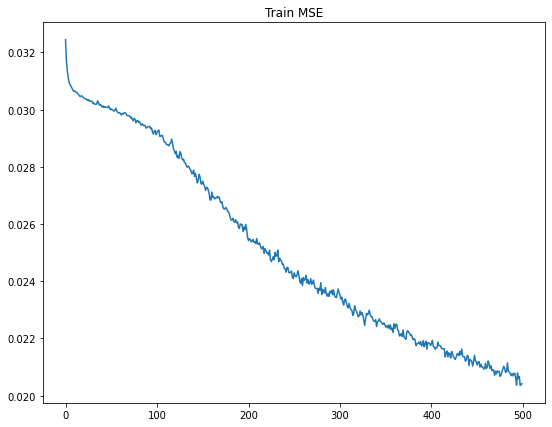

In [7]:
fig, ax1 = plt.subplots(1,1, figsize=(9, 7))
ax1.plot(epochs_losses_train)
ax1.set_title("Train MSE")

In [8]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}, "C:\\Users\\nikos\\Desktop\\denoising\\new_model_tests\\synthetic-train-3.pth")


# Testing on synthetic data

In [9]:
model.eval().to(torch.device('cpu'));

In [10]:
# Reconstruct just one file for now.
eval_sample = np.load('synthetic-data\\test\\waveforms-test.npy')[:,32:]
N_ch = eval_sample.shape[0]
N_t = eval_sample.shape[1]

""" Prepare samples and masks """
masks = np.ones((N_ch, N_sub, N_t))
eval_samples = np.zeros_like(masks)

gutter = N_sub // 2
mid = N_sub // 2

for i in range(gutter):
    masks[i, i] = 0
    eval_samples[i, :, :] = eval_sample[:N_sub]

for i in range(gutter, N_ch - gutter):
    start = i - mid
    stop = i + mid if N_sub % 2 == 0 else i + mid + 1

    masks[i, mid] = 0
    eval_samples[i, :, :] = eval_sample[start:stop]

for i in range(N_ch - gutter, N_ch):
    masks[i, i - N_ch] = 0
    eval_samples[i, :, :] = eval_sample[-N_sub:]

sample = eval_samples * masks
sample = torch.unsqueeze(torch.Tensor(sample).squeeze(), 1)
c_mask = (1-masks)
output = model(sample).detach().squeeze()*c_mask
output = output.sum(axis=1)


In [11]:
output_ = taper_filter(output, 1, 10, sampleRate)

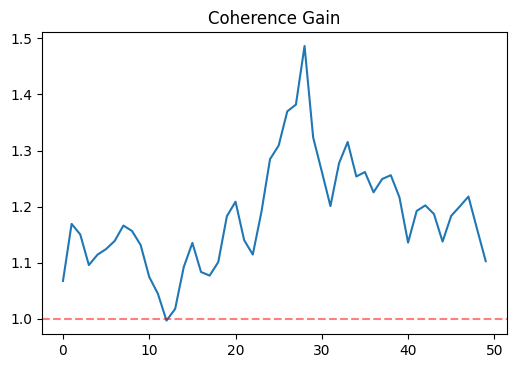

In [24]:
og = np.array(eval_sample)
rec = np.array(output_)
bin_size = 16
cc_og = compute_moving_coherence(og, bin_size)
cc_rec = compute_moving_coherence(rec, bin_size)
cc_gain = cc_rec / cc_og
plt.figure(dpi=100)
plt.plot(cc_gain)
plt.title("Coherence Gain")
plt.axhline(y=1,linestyle='--',alpha=0.5,color='r')

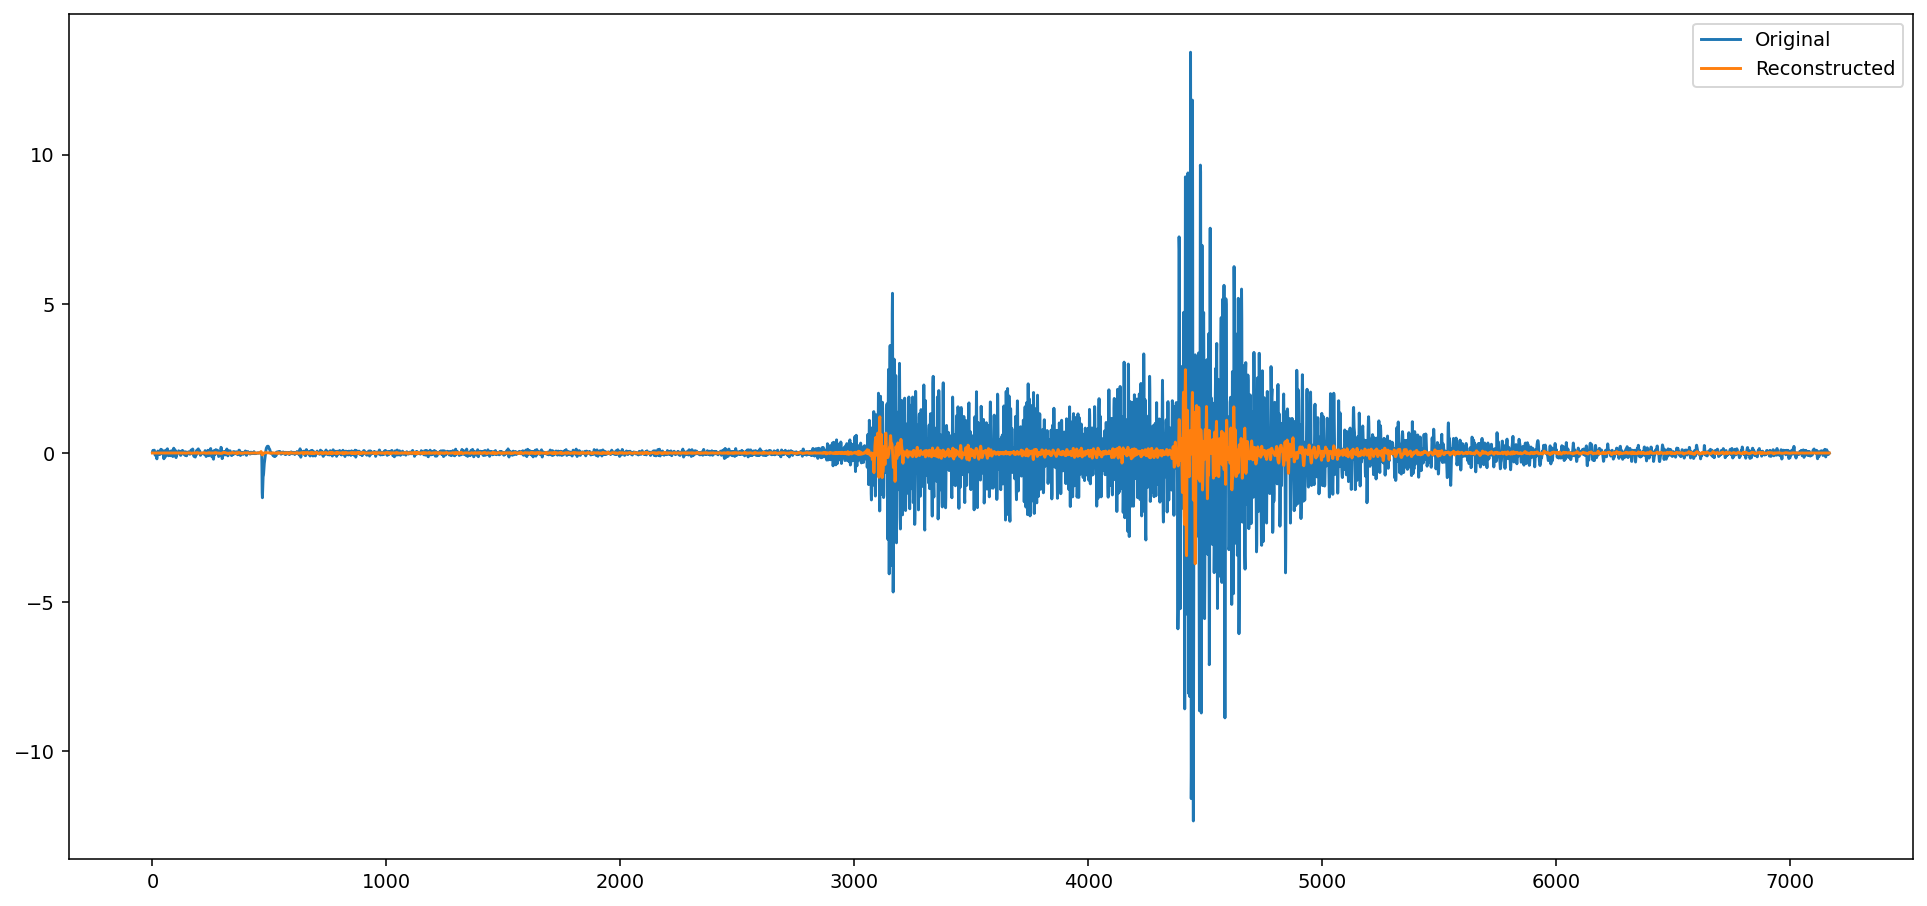

In [27]:
channel=0
plt.figure(figsize=(17,8),dpi=140)
plt.plot(eval_sample[channel],label='Original')
plt.plot(output_[channel],label='Reconstructed')
plt.legend()